In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'data/OnlineRetail.xlsx'
data = pd.read_excel(file_path)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Data Preprocessing
# Aggregate data to create a customer-level dataset
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceNo': 'nunique'
}).reset_index()

# Calculate total spending per customer
customer_data['TotalSpending'] = customer_data['Quantity'] * customer_data['UnitPrice']

# Define high-value customers as those in the top 25% of total spending
threshold = customer_data['TotalSpending'].quantile(0.75)
customer_data['CustomerValue'] = (customer_data['TotalSpending'] > threshold).astype(int)


In [6]:
# Features and target variable
X = customer_data[['Quantity', 'UnitPrice', 'InvoiceNo', 'TotalSpending']]
y = customer_data['CustomerValue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [7]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


In [8]:
# Define the parameter grid
param_grid = {'knn__n_neighbors': range(1, 11)}
f1_scorer = make_scorer(f1_score)

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 11)},
             scoring=make_scorer(f1_score))

In [19]:
# Best model and performance on test set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
best_params = grid_search.best_params_
results = {
    "Best Parameters": best_params,
    "Accuracy on Test Set": accuracy,
    "F1 Score on Test Set": f1,
    "Precision on Test Set": precision,
    "Recall on Test Set": recall,
    "Classification Report": classification_rep,
    "Confusion Matrix": conf_matrix
}

# Print the results
print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy)
print("F1 Score on Test Set:", f1)
print("Precision on Test Set:", precision)
print("Recall on Test Set:", recall)

Best Parameters: {'knn__n_neighbors': 3}
Accuracy on Test Set: 0.9611280487804879
F1 Score on Test Set: 0.9204368174726989
Precision on Test Set: 0.9104938271604939
Recall on Test Set: 0.9305993690851735


In [20]:
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       995
           1       0.91      0.93      0.92       317

    accuracy                           0.96      1312
   macro avg       0.94      0.95      0.95      1312
weighted avg       0.96      0.96      0.96      1312

Confusion Matrix:
 [[966  29]
 [ 22 295]]


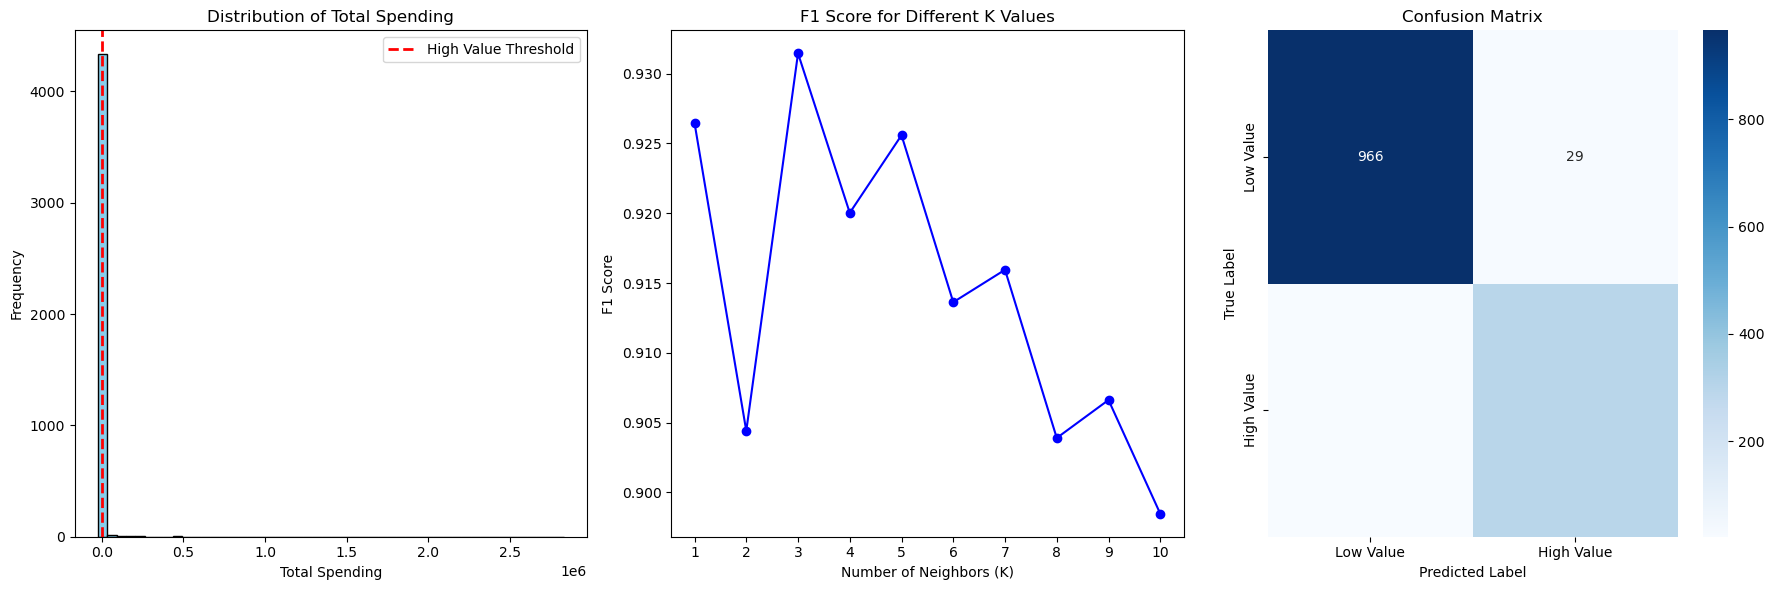

In [10]:
# Plotting
plt.figure(figsize=(18, 6))

# Plot Total Spending Distribution
plt.subplot(1, 3, 1)
plt.hist(customer_data['TotalSpending'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='High Value Threshold')
plt.title('Distribution of Total Spending')
plt.xlabel('Total Spending')
plt.ylabel('Frequency')
plt.legend()

# Plot F1 Score for Different K Values
f1_scores = grid_search.cv_results_['mean_test_score']
k_values = range(1, 11)

plt.subplot(1, 3, 2)
plt.plot(k_values, f1_scores, marker='o', color='blue')
plt.title('F1 Score for Different K Values')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('F1 Score')
plt.xticks(k_values)

# Plot Confusion Matrix
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low Value', 'High Value'], yticklabels=['Low Value', 'High Value'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


### Summary of Results
Best Parameters:

Number of Neighbors (K): 3
Performance Metrics on Test Set:

Accuracy: 0.961 (96.1%)
F1 Score: 0.920 (92.0%)
Precision: 0.910 (91.0%)
Recall: 0.931 (93.1%)

### Confusion Matrix:

True Positive (High Value correctly classified): 295
False Negative (High Value incorrectly classified): 22
True Negative (Low Value correctly classified): 966
False Positive (Low Value incorrectly classified): 29

### Analysis

Accuracy:

The model achieved an accuracy of 96.1%, which is very high. This indicates that 96.1% of the predictions made by the model are correct.

F1 Score:

The F1 score of 0.92 shows a good balance between precision and recall, especially important in cases of imbalanced datasets. It indicates that the model has a good harmonic mean of precision and recall, ensuring both false positives and false negatives are minimized.
Precision:

The precision for predicting high-value customers is 91%, meaning that 91% of the customers identified as high-value are actually high-value.

Recall:

The recall for high-value customers is 93.1%, indicating that the model correctly identifies 93.1% of all actual high-value customers. This is crucial for ensuring that high-value customers are not missed.

Confusion Matrix:

The confusion matrix shows that out of 317 actual high-value customers, 295 were correctly identified, and only 22 were misclassified as low-value.
For low-value customers, out of 995, 966 were correctly identified, with 29 misclassified as high-value.

## Conclusion

Is the Model Good?

Yes, the model appears to be good based on the following factors:

High Accuracy: The model's accuracy of 96.1% is excellent, indicating strong overall performance.
Balanced F1 Score: A high F1 score of 0.92 suggests a good balance between precision and recall, which is critical for handling imbalanced classes.

Strong Precision and Recall: Both precision (91%) and recall (93.1%) for high-value customers are high, demonstrating that the model is effective at identifying high-value customers while minimizing false positives and false negatives.

# Overall:

The model performs well and is reliable for predicting high-value customers, making it suitable for applications such as personalized marketing and customer segmentation in an e-commerce context. However, it is important to continuously monitor the model's performance and retrain it with new data to maintain its accuracy and relevance.

